In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras import layers, models

plt.style.use('seaborn')


<ipython-input-1-8042bd9b032e>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:

(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = tf.keras.datasets.mnist.load_data()

# Combine into one dataset of 70k
x_all = np.concatenate([x_train_orig, x_test_orig], axis=0)
y_all = np.concatenate([y_train_orig, y_test_orig], axis=0)

print("Combined dataset shape:", x_all.shape, y_all.shape)  # (70000, 28, 28), (70000,)

# 80:20 split
x_train, x_test, y_train, y_test = train_test_split(
    x_all, 
    y_all, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print("Train set shape:", x_train.shape, y_train.shape)  # (56000, 28, 28), (56000,)
print("Test set shape:", x_test.shape, y_test.shape)      # (14000, 28, 28), (14000,)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Combined dataset shape: (70000, 28, 28) (70000,)
Train set shape: (56000, 28, 28) (56000,)
Test set shape: (14000, 28, 28) (14000,)


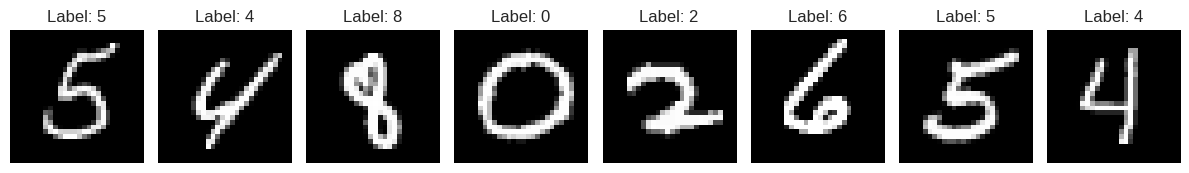

In [3]:
plt.figure(figsize=(12,3))
num_samples_to_plot = 8
for i in range(num_samples_to_plot):
    plt.subplot(1, num_samples_to_plot, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
# Scale
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Flatten (28×28 -> 784)
x_train_flat = x_train.reshape(-1, 784)
x_test_flat  = x_test.reshape(-1, 784)

print("x_train_flat:", x_train_flat.shape)  # (56000, 784)
print("x_test_flat:", x_test_flat.shape)    # (14000, 784)


x_train_flat: (56000, 784)
x_test_flat: (14000, 784)


In [5]:
pca = PCA(n_components=4)
pca.fit(x_train_flat)  # learns 4 principal components from the training set

# Transform train and test
x_train_pca_4D = pca.transform(x_train_flat)
x_test_pca_4D  = pca.transform(x_test_flat)

print("x_train_pca_4D:", x_train_pca_4D.shape)  # (56000, 4)
print("x_test_pca_4D:", x_test_pca_4D.shape)    # (14000, 4)


x_train_pca_4D: (56000, 4)
x_test_pca_4D: (14000, 4)


In [6]:
# Inverse transform from 4D back to 784D, then reshape to 28×28
x_test_pca_reconstructed = pca.inverse_transform(x_test_pca_4D)
x_test_pca_reconstructed = x_test_pca_reconstructed.reshape(-1, 28, 28)


In [7]:
latent_dim = 4

# Encoder
input_img = tf.keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(32, activation='relu')(encoded)
latent = layers.Dense(latent_dim, activation='linear')(encoded)

# Decoder
decoded_input = layers.Dense(32, activation='relu')(latent)
decoded_input = layers.Dense(128, activation='relu')(decoded_input)
decoded = layers.Dense(784, activation='sigmoid')(decoded_input)

# AutoEncoder model
autoencoder = tf.keras.Model(inputs=input_img, outputs=decoded, name="AE_4D")
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "AE_4D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         101,136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 210,260 (821.33 KB)

 Trainable params: 210,260 (821.33 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = autoencoder.fit(
    x_train_flat, x_train_flat,  # input = output
    validation_split=0.1,        # 10% of 56k (~5600) for validation
    epochs=10,
    batch_size=256,
    shuffle=True,
    verbose=1
)


Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1081 - val_loss: 0.0509
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0478 - val_loss: 0.0408
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0401 - val_loss: 0.0374
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0370 - val_loss: 0.0356
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0357 - val_loss: 0.0344
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343 - val_loss: 0.0334
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334 - val_loss: 0.0327
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0328 - val_loss: 0.0322
Epoch 9/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321 - val_loss: 0.0316
Epoch 10/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317 - val_loss: 0.0313


In [9]:
# Create an Encoder model
encoder = tf.keras.Model(inputs=input_img, outputs=latent)
encoder.summary()

# Encode test images (4D)
x_test_ae_4D = encoder.predict(x_test_flat)
print("x_test_ae_4D shape:", x_test_ae_4D.shape)  # (14000, 4)

# Build a Decoder model
latent_input = tf.keras.Input(shape=(latent_dim,))
layer_1 = autoencoder.layers[-3]
layer_2 = autoencoder.layers[-2]
output_layer = autoencoder.layers[-1]

dec_layer_1 = layer_1(latent_input)
dec_layer_2 = layer_2(dec_layer_1)
dec_output  = output_layer(dec_layer_2)

decoder = tf.keras.Model(inputs=latent_input, outputs=dec_output)
decoder.summary()

# Reconstruct from 4D
x_test_ae_reconstructed = decoder.predict(x_test_ae_4D)
x_test_ae_reconstructed = x_test_ae_reconstructed.reshape(-1, 28, 28)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,740 (409.14 KB)

 Trainable params: 104,740 (409.14 KB)

 Non-trainable params: 0 (0.00 B)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
x_test_ae_4D shape: (14000, 4)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         101,136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,520 (412.19 KB)

 Trainable params: 105,520 (412.19 KB)

 Non-trainable params: 0 (0.00 B)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [10]:
n_samples_tsne = 2000
indices = np.random.choice(len(x_test), n_samples_tsne, replace=False)

pca_4D_subset = x_test_pca_4D[indices]
ae_4D_subset  = x_test_ae_4D[indices]
labels_subset = y_test[indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

pca_2D = tsne.fit_transform(pca_4D_subset)
ae_2D  = tsne.fit_transform(ae_4D_subset)


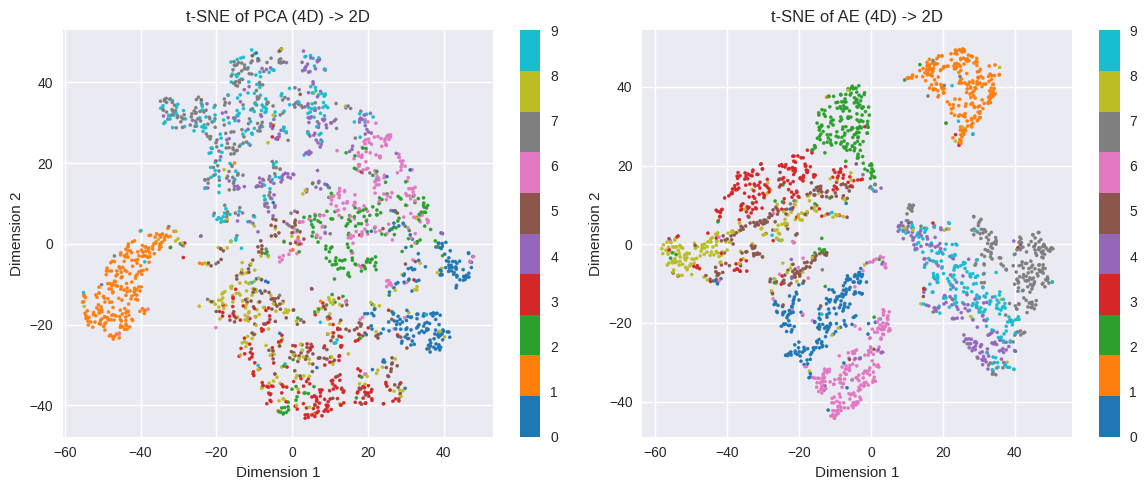

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(pca_2D[:,0], pca_2D[:,1], c=labels_subset, cmap='tab10', s=5)
plt.colorbar()
plt.title("t-SNE of PCA (4D) -> 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1,2,2)
plt.scatter(ae_2D[:,0], ae_2D[:,1], c=labels_subset, cmap='tab10', s=5)
plt.colorbar()
plt.title("t-SNE of AE (4D) -> 2D")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.tight_layout()
plt.show()


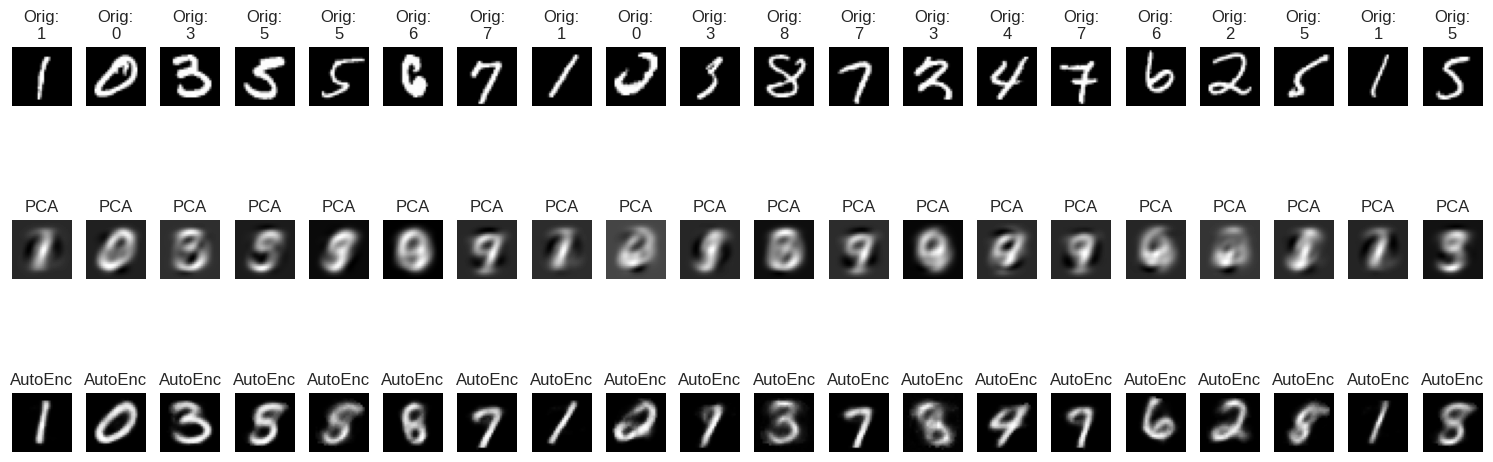

In [12]:
num_show = 20
indices_show = np.random.choice(len(x_test), num_show, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(indices_show):
    # Original
    plt.subplot(3, num_show, i+1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"Orig:\n{y_test[idx]}")
    plt.axis("off")
    
    # PCA Recon
    plt.subplot(3, num_show, i+1+num_show)
    plt.imshow(x_test_pca_reconstructed[idx], cmap='gray')
    plt.title("PCA")
    plt.axis("off")

    # AE Recon
    plt.subplot(3, num_show, i+1+2*num_show)
    plt.imshow(x_test_ae_reconstructed[idx], cmap='gray')
    plt.title("AutoEnc")
    plt.axis("off")

plt.tight_layout()
plt.show()


**Compression Ratio = 784/4 = 196 :1**